In [119]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier  
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import normalize, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/home/hasan/Desktop/Code to keep on Github/Cardiovascular Disease/cardio_train.csv", sep=';').drop('id', axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Check missing values

In [4]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

There are no missing data!

### Check duplicate values

In [5]:
df.duplicated().sum()

24

There are 24 duplicated data! So we need to drop those data

In [6]:
# Dropping duplicate values
df.drop_duplicates(inplace=True)
print("number of duplicated data after dropping :",df.duplicated().sum())

number of duplicated data after dropping : 0


### Data Describe

In [7]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In ap_hi and ap_lo have some outlier!

### Outlier Checking and Dropping

In [8]:
std_list = ["age", "height", "weight", "ap_hi", "ap_lo"] 

def standartization(x):
    x_std = x.copy(deep=True)
    for column in std_list:
        x_std[column] = (x_std[column] - x_std[column].mean()) / x_std[column].std() 
    return x_std

df_std = standartization(df)
df_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [9]:
# Melting data for multi box plot
df_melt = pd.melt(frame=df_std, id_vars='cardio', value_vars=std_list, var_name='features', value_name='value', col_level=None)
df_melt

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'age'),
  Text(1, 0, 'height'),
  Text(2, 0, 'weight'),
  Text(3, 0, 'ap_hi'),
  Text(4, 0, 'ap_lo')])

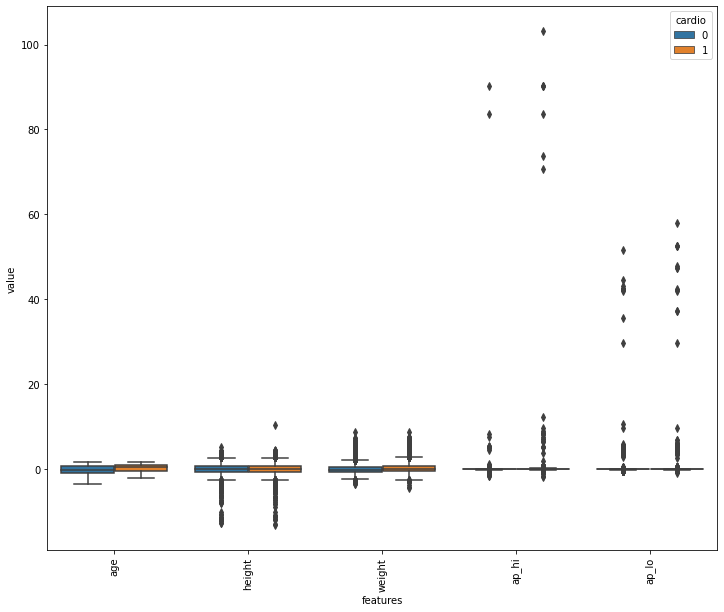

In [10]:
# Box plot
plt.figure(figsize=(12, 10))
sns.boxplot(x='features', y='value', hue='cardio', data=df_melt)
plt.xticks(rotation=90)

It is clear that in ap_hi and ap_lo have some unusual outlier!

In [11]:
# Diciding upper and lower bound 
ap_list = ['ap_hi', 'ap_lo']
df_ap = pd.DataFrame(index=['lower_bound', 'upper_bound'])

for each in ap_list:
    Q1 = df[each].quantile(0.25)
    Q3 = df[each].quantile(0.75)
    IQR = Q3 - Q1
    
    lowr_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df_ap[each] = [lowr_bound, upper_bound]
    
df_ap.head()

,ap_hi,ap_lo
lower_bound,90.0,65.0
upper_bound,170.0,105.0


<AxesSubplot:xlabel='cardio', ylabel='count'>

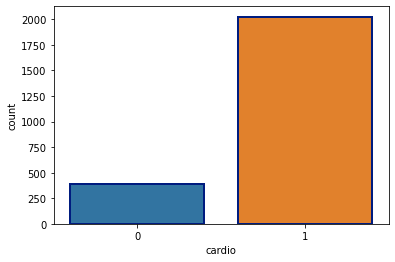

In [12]:
# Outlier rows
ap_hi_filter = (df['ap_hi'] > df_ap['ap_hi'][1])
ap_lo_filter = (df['ap_lo'] > df_ap['ap_lo'][1])
outlier_filter = (ap_hi_filter | ap_lo_filter)
df_outlier = df[outlier_filter]

# graph of outlier
sns.countplot(x='cardio', data=df_outlier, linewidth=2, edgecolor=sns.color_palette("dark", 1))


In [13]:
# taking less than 250 in ap_hi and less than 200 in ap_lo
outlier_filter = ((df["ap_hi"]>250) | (df["ap_lo"]>200) )
df = df[~outlier_filter]
df.shape

(68983, 12)

### Day to Year of age column

In [14]:
df['age'] = (df['age']/365).round().astype('int')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


### New column of weight

In [15]:
def weight_func(x):
    if x <= 50:
         return 1
        
    if x > 50  and x <= 100:
         return 2
        
    if x >100 and x<= 150:
         return 3
        
    else:
         return 4

    

In [16]:
df['weight_class'] = df['weight'].apply(lambda x: weight_func(x))

### New column of age 

In [17]:
def age_func(x):
    if x <= 40:
         return 1
        
    if x > 40  and x <= 50:
         return 2
        
    if x > 50 and x <= 60:
         return 3
        
    else:
         return 4


In [18]:
df['age_class'] = df['age'].apply(lambda x: age_func(x))

### New column of body mass index

In [19]:
df['bmi'] = df['weight'] / (df['height']/100)**2
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_class,age_class,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,2,2,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,2,3,34.927679
2,52,1,165,64.0,130,70,3,1,0,0,0,1,2,3,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,2,2,28.710479
4,48,1,156,56.0,100,60,1,1,0,0,0,0,2,2,23.011177


### Preprocessing gender column

In [20]:
df['gender'] = df['gender'].apply(lambda x: 0 if x==1 else 1)

In [21]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_class,age_class,bmi
0,50,1,168,62.0,110,80,1,1,0,0,1,0,2,2,21.967120
1,55,0,156,85.0,140,90,3,1,0,0,1,1,2,3,34.927679
2,52,0,165,64.0,130,70,3,1,0,0,0,1,2,3,23.507805
3,48,1,169,82.0,150,100,1,1,0,0,1,1,2,2,28.710479
4,48,0,156,56.0,100,60,1,1,0,0,0,0,2,2,23.011177


### Crrelation

<AxesSubplot:>

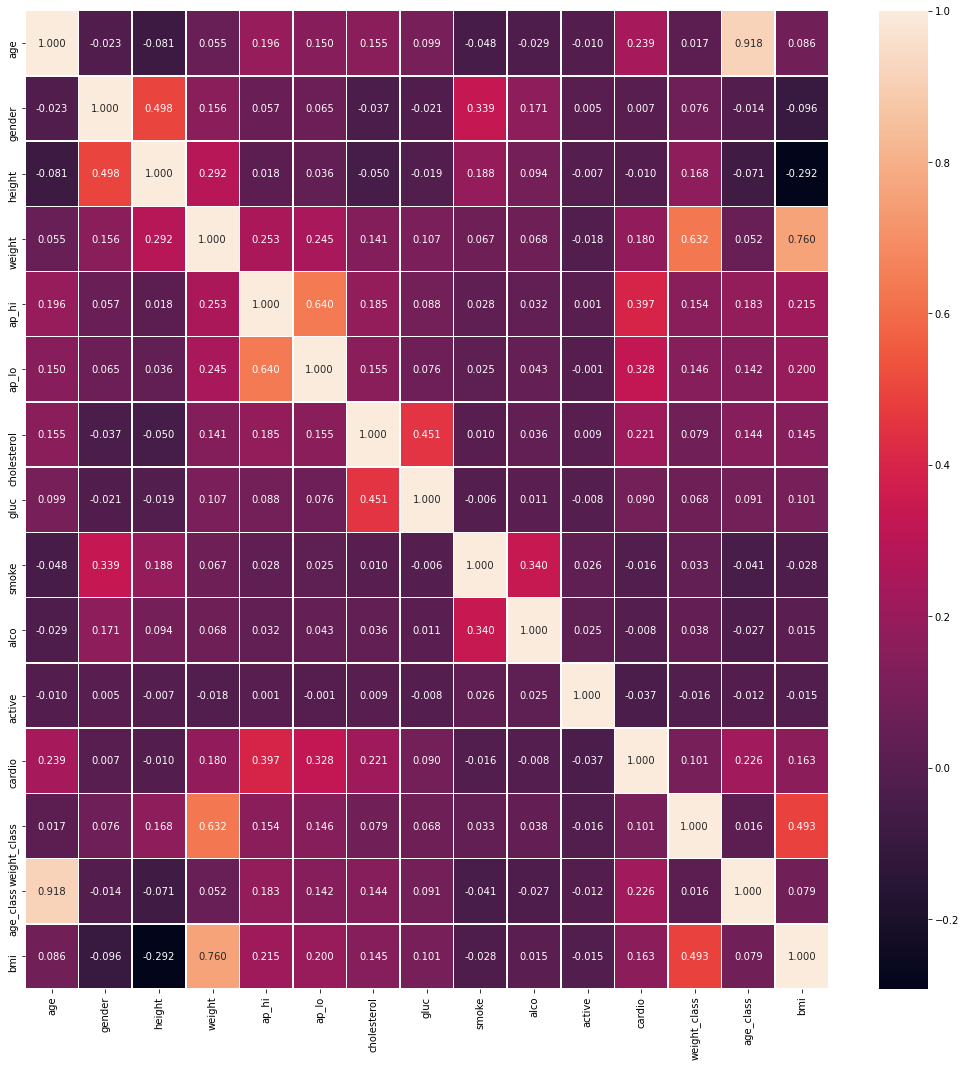

In [22]:
corr = df.corr()
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr, annot=True, fmt='.3f', linewidths=0.5, ax=ax)

### Feature Selection

In [51]:
X = df.drop('cardio', axis=1)
y = df.cardio

In [52]:
# scaling because of the negative number
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

In [53]:
feature = SelectKBest(chi2, k=14)
score = feature.fit(scaled,y)

In [50]:
score.shape

(68983, 10)

In [55]:
scores = pd.DataFrame(score.scores_)
scores.columns = ['feature_score']
scores

,feature_score
0,221.761322
1,2.497316
2,0.023557
3,38.418327
4,32.348224
5,18.464979
6,2136.186973
7,401.984555
8,16.863597
9,4.336999


In [60]:
columns = pd.DataFrame(X.columns)
feature_score = pd.concat([columns, scores], axis=1) 
feature_score.sort_values(by='feature_score', ascending=False)

,0,feature_score
6,cholesterol,2136.186973
7,gluc,401.984555
12,age_class,379.602397
0,age,221.761322
3,weight,38.418327
4,ap_hi,32.348224
10,active,18.855791
5,ap_lo,18.464979
8,smoke,16.863597
11,weight_class,15.796485


#### Feature Importance Using ExtraTreeClassifier

In [27]:
etc = ExtraTreesClassifier(n_estimators=100)
etc.fit(X,y)

ExtraTreesClassifier()

In [29]:
print(etc.feature_importances_)

[0.09969054 0.00958252 0.15114979 0.15204169 0.18470178 0.10652259
 0.04660461 0.01639154 0.00612762 0.00611108 0.00827265 0.00762517
 0.02943467 0.17574375]


In [31]:
#scores with columns
column_scores = pd.Series(etc.feature_importances_, X.columns)
column_scores.sort_values(ascending=False)

ap_hi           0.184702
bmi             0.175744
weight          0.152042
height          0.151150
ap_lo           0.106523
age             0.099691
cholesterol     0.046605
age_class       0.029435
gluc            0.016392
gender          0.009583
active          0.008273
weight_class    0.007625
smoke           0.006128
alco            0.006111
dtype: float64

I am not going to reduce any feature!

### shuffle dataset

In [61]:
df = df.sample(frac=1).reset_index(drop=True)

### Dividing Dataset

In [62]:
X = df.drop('cardio', axis=1)
y = df.cardio
print("Shape of X is :", X.shape, "Shape of y is :", y.shape)

Shape of X is : (68983, 14) Shape of y is : (68983,)


In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Machine Learning Algorithms

In [64]:
algs = {
    "logistic_regression": LogisticRegression(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "support_vector machine": SVC(),
    "linear_svc": LinearSVC(),
    "perceptron": Perceptron(),
    "gaussian_naive bayes": GaussianNB(),
    "k nearest_neighbors": KNeighborsClassifier(),
    "sgdclassifier": SGDClassifier(),
    "xgboost": XGBClassifier(),
    "lgbm_classifier": LGBMClassifier(),
    "gradient_boosting": GradientBoostingClassifier(),
    "ridge_classifier": RidgeClassifier(),
    "bagging_classifier": BaggingClassifier(),
    "extra_tree_classifier": ExtraTreesClassifier(),
    "adaboost_classifier": AdaBoostClassifier()
}


In [65]:
result = pd.DataFrame(columns=['train_accuracy', 'test_accuracy', 'f1_score'])

for key, value in algs.items():
    value.fit(x_train, y_train)
    train_acc = round(value.score(x_train, y_train)*100, 2)  
    predicted = value.predict(x_test)
    result.loc[key] = [train_acc, 100* np.round(accuracy_score(y_test, predicted), decimals=4),
                      round(f1_score(y_test, predicted), 2)]
    
# Printing result dataframe  
result = result.sort_values(by=['test_accuracy', 'train_accuracy'], ascending=False)
result

,train_accuracy,test_accuracy,f1_score
lgbm_classifier,74.70,73.86,0.73
gradient_boosting,73.60,73.83,0.73
xgboost,76.29,73.42,0.72
adaboost_classifier,72.78,73.26,0.71
logistic_regression,72.41,72.94,0.71
ridge_classifier,72.29,72.91,0.71
support_vector machine,72.14,72.70,0.70
sgdclassifier,71.55,71.99,0.68
random_forest,97.61,70.93,0.71
gaussian_naive bayes,69.76,70.00,0.66


# Hyperparameter Tuning with Random Forest

I am not going to run those model with hyperparameter because it takes huge time!

In [27]:
rfc = RandomForestClassifier() 

In [28]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper_params = dict(n_estimators = n_estimators, 
                    max_depth = max_depth,  
                    min_samples_split = min_samples_split, 
                    min_samples_leaf = min_samples_leaf)

In [ ]:
grid_s_cv = GridSearchCV(rfc, hyper_params, cv=3)
grid_s_cv.fit(x_train, y_train)

In [ ]:
grid_s_cv.best_params_

In [66]:
# training with hyperparameter
rfc_hyp = RandomForestClassifier() 
rfc_hyp.fit(x_train, y_train)

RandomForestClassifier()

In [67]:
rfc_predicted = rfc_hyp.predict(x_test)

#### Classification Report

In [69]:
print(classification_report(y_test, rfc_predicted))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      6904
           1       0.71      0.70      0.70      6893

    accuracy                           0.71     13797
   macro avg       0.71      0.71      0.71     13797
weighted avg       0.71      0.71      0.71     13797



#### Confusion Matrix

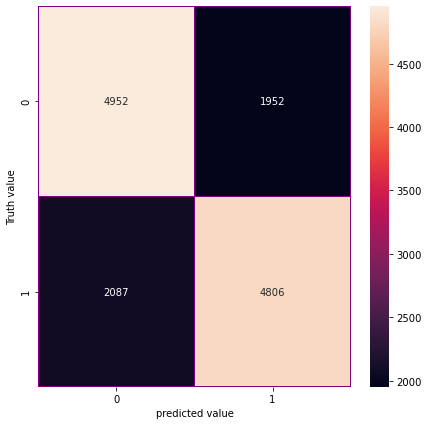

In [70]:
cm = confusion_matrix(y_test, rfc_predicted)
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()

# Hyperparameter Tuning with XGBoost

In [ ]:
xgb = XGBClassifier()

In [ ]:
hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth':[2, 3, 5, 10, 15],
    'learning_rate':[0.05,0.1,0.15,0.20],
    'min_child_weight':[1,2,3,4],
    'booster':['gbtree','gblinear'],
    'base_score':[0.25,0.5,0.75,1]
    }


In [ ]:
random_cv = RandomizedSearchCV(estimator=xgb,
            param_distributions=hyperparameter_grid,
            cv=3, 
            n_iter=50,
            scoring = 'neg_mean_absolute_error',
            n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)


In [ ]:
random_cv.fit(x_train, y_train)


In [ ]:
random_cv.best_estimator_

In [71]:
# Training
xgb_hyp = XGBClassifier()
xgb_hyp.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
# predicting 
xgb_predicted = xgb_hyp.predict(x_test)

In [74]:
# Classification Report
print(classification_report(y_test, xgb_predicted))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6904
           1       0.76      0.68      0.72      6893

    accuracy                           0.73     13797
   macro avg       0.74      0.73      0.73     13797
weighted avg       0.74      0.73      0.73     13797



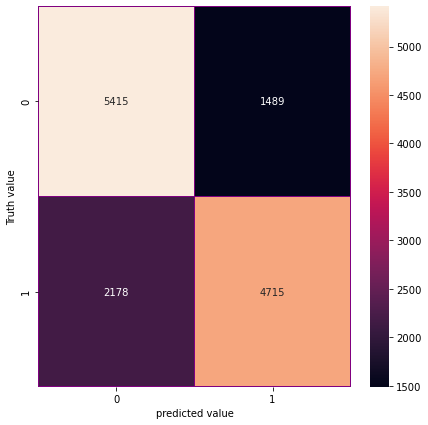

In [75]:
# Confusion Matrix 
cm = confusion_matrix(y_test, xgb_predicted)
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()

### Using Cross_val_score

In [76]:
xgb_cvs = XGBClassifier()
cvs = cross_val_score(xgb_cvs, X, y, cv=5)
cvs

array([0.73363775, 0.72979633, 0.72907154, 0.72586257, 0.73492317])

In [77]:
cvs.mean()

0.7306582704317605

# Hyperparameter tuning with LGBMClassifier

In [ ]:
lgbmc = LGBMClassifier()

In [78]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3


In [79]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_test, y_test)],
            'eval_names': ['valid'],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}


In [80]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [82]:
lgbmc = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
                        estimator=lgbmc, 
                        param_distributions=param_test, 
                        n_iter=100,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=314,
                        verbose=True)


In [83]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [84]:
clf_sw = LGBMClassifier(**lgbmc.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [85]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)


In [86]:
gs_sample_weight.fit(x_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's auc: 0.803137
Early stopping, best iteration is:
[87]	valid's auc: 0.803192
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.803375
Early stopping, best iteration is:
[160]	valid's auc: 0.803537
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.802904
Early stopping, best iteration is:
[133]	valid's auc: 0.803176
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.802911
[200]	valid's auc: 0.803276
[300]	valid's auc: 0.80338
[400]	valid's auc: 0.80342
[500]	valid's auc: 0.803437
[600]	valid's auc: 0.803447
[700]	valid's auc: 0.803458
[800]	valid's auc: 0.803463
[900]	valid's auc: 0.803469
Early stopping, best iteration is:
[906]	valid's auc: 0.803471
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.802778
Early stopping, best iteration is:
[70]	valid's auc: 0.802817
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   21.0s finished


[100]	valid's auc: 0.80332
Early stopping, best iteration is:
[99]	valid's auc: 0.803359
Best score reached: 0.8001349774041705 with params: {'scale_pos_weight': 1} 


In [ ]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                                         gs_sample_weight.cv_results_['mean_test_score'][i], 
                                                         gs_sample_weight.cv_results_['mean_train_score'][i],
                                                         gs_sample_weight.cv_results_['std_test_score'][i]))
    

### Final Model

In [88]:
lgbmc_hyp = LGBMClassifier(**lgbmc.get_params())
lgbmc_hyp.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [91]:
lgbmc_hyp.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.80332
Early stopping, best iteration is:
[99]	valid's auc: 0.803359


LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [93]:
# Predicting with test data
lgbmc_predicted = lgbmc_hyp.predict(x_test)

In [95]:
# classification report
print(classification_report(y_test, lgbmc_predicted))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6904
           1       0.76      0.69      0.72      6893

    accuracy                           0.74     13797
   macro avg       0.74      0.74      0.74     13797
weighted avg       0.74      0.74      0.74     13797



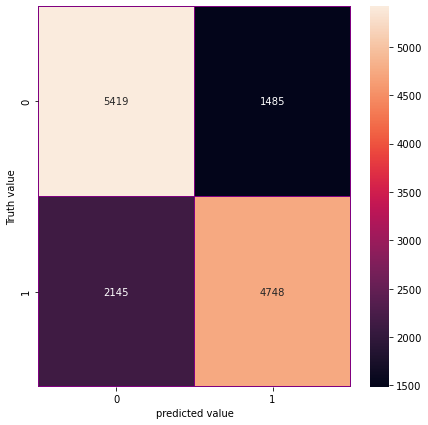

In [96]:
# Confusion Matrix 
cm = confusion_matrix(y_test, lgbmc_predicted)
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()

### Voting Classifier

In [98]:
vot_cls = VotingClassifier(estimators=[('lr', rfc_hyp), ('rf', xgb_hyp), ('ab', lgbmc_hyp)], voting='hard')

for clf, label in zip([rfc_hyp, xgb_hyp, lgbmc_hyp, vot_cls],
                      ['Random forest classifier', 'XGBClassifier', "LGBM classifier", "Ensemble"]):
    scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))
    

Accuracy: 0.71 (+/- 0.01) [Random forest classifier]
Accuracy: 0.73 (+/- 0.01) [XGBClassifier]
Accuracy: 0.72 (+/- 0.00) [LGBM classifier]
Accuracy: 0.73 (+/- 0.00) [Ensemble]


In [99]:
# train score of voting classifier
vot_cls.fit(x_train, y_train)
train_acc = round(vot_cls.score(x_train, y_train)*100, 2) 
train_acc

80.07

In [101]:
# test score of voting classifier
test_acc = round(vot_cls.score(x_test, y_test)*100, 2)
test_acc

73.25

# Using Neural Network

In [102]:
# Neural Network
Model1 = Sequential()
Model1.add(Dense(7, input_dim=14, activation='relu'))
Model1.add(Dense(1, activation='sigmoid'))

In [105]:
# Deep Neural Network
model2 = Sequential()
model2.add(Dense(14, input_dim=14, activation='relu'))
model2.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))


In [107]:
# Model Summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                750       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [108]:
# Model Compile
optimizer = RMSprop(learning_rate=0.002)
model2.compile(loss='binary_crossentropy', 
              metrics=['accuracy'], 
              optimizer=optimizer)

In [109]:
# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau( 
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.1,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=50,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing;                    
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=400, 
                   restore_best_weights=True)

In [111]:
# Model Training
history = model2.fit(x_train, y_train.values,
                    batch_size=1024, 
                    epochs=1500,
                    verbose=0,
                    validation_split=0.15,
                    callbacks=[learning_rate_reduction, early_stopping],
                    shuffle=True)


Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 1e-05.
Restoring model weights from the end of the best epoch.
Epoch 00521: early stopping


In [112]:
# Model Evaluate
model2.evaluate(x_test, y_test.values, verbose=2)

432/432 - 0s - loss: 0.5459 - accuracy: 0.7321


[0.5458774566650391, 0.7321156859397888]

### Accuracy and Loss of Training

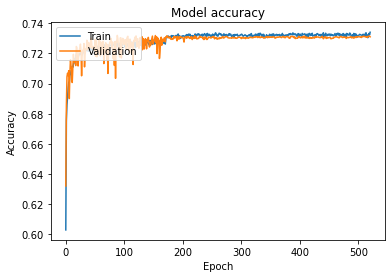

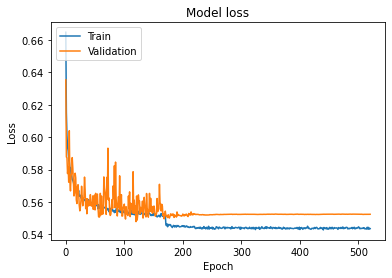

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<AxesSubplot:>

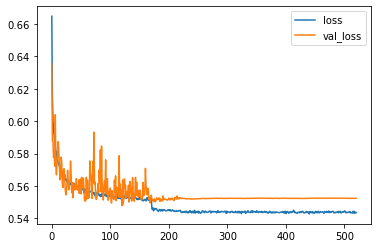

In [115]:
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

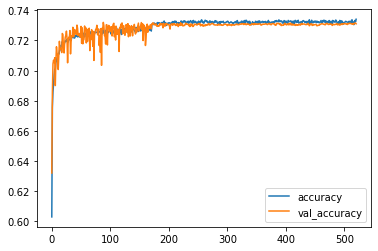

In [116]:
losses = pd.DataFrame(history.history)
losses[['accuracy','val_accuracy']].plot()

### Model Saving and Loading

In [117]:
model2.save("Cardiovascular_Disease.h5") 

In [121]:
loaded_model = load_model("Cardiovascular_Disease.h5")

### Predicting with test data

In [122]:
ann_predicted = loaded_model.predict(x_test)

### Classification Report

In [125]:
print(classification_report(y_test, ann_predicted.round()))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6904
           1       0.78      0.65      0.71      6893

    accuracy                           0.73     13797
   macro avg       0.74      0.73      0.73     13797
weighted avg       0.74      0.73      0.73     13797



### Confusion Matrix

In [126]:
cm = confusion_matrix(y_test, ann_predicted.round()) 

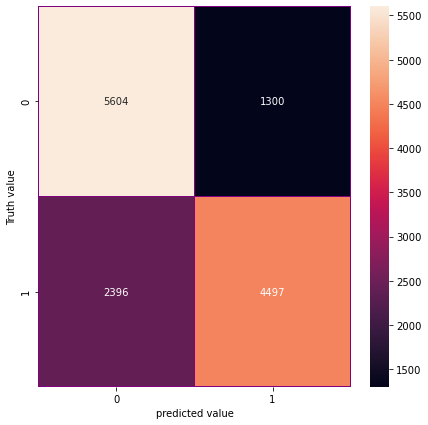

In [127]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()